In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

In [2]:
def get_significant(file_path):
    significants = []
    with open(file_path, "r") as f:
        datas = f.readlines()
        for data in datas[1:]:
            data = data.split()
            x, y = int(int(data[1])/1000), int(int(data[3])/1000)
            p_value, q_value = float(data[5]), float(data[6])
            concat = int(data[4])
            significants.append((x, y, p_value, q_value, concat))
    return significants

def cal_significant(significants, proportion):
    test = np.array(significants)
    
    def _filter(_values, max_nums, test):
        values_sort_index = _values.argsort()
        values_min_numbers_index = values_sort_index[max_nums-1]
        p = max_nums
        values_min_indexs = _values.argsort()[:p-1]
        _test = test[values_min_indexs, :]
        return _test

    _p_values = test[:, 2]
    _test = _filter(_p_values, int(_p_values.shape[0]*proportion), test)
    _q_values = _test[:, 3]
    _test = _filter(_q_values, int(_q_values.shape[0]*proportion), _test)
    return _test

def cal_significant_test(significants, proportion):
    test = np.array(significants)

    test = test[np.argsort(test[:, 2])]
    _test = np.zeros((int(test.shape[0]*proportion), 5))
    significant_set = set()
    index = 0
    for i in range(test.shape[0]):
        x, y = int(test[i, 0]), int(test[i, 1])
        flag = False
        for _x in range(x-4, x+5):
            for _y in range(y-4, y+5):
                if (_x, _y) in significant_set:
                    flag = True
                    break
            if flag:
                break
        if flag:
            continue
        significant_set.add((x, y))
        _test[index] = test[i]
        index += 1
        if index > _test.shape[0] - 1:
            break
    
    def _filter(_values, max_nums, test):
        values_sort_index = _values.argsort()
        values_min_numbers_index = values_sort_index[max_nums-1]
        p = max_nums
        values_min_indexs = _values.argsort()[:p-1]
        _test = test[values_min_indexs, :]
        return _test

    _q_values = _test[:, 3]
    _test = _filter(_q_values, int(_q_values.shape[0]*proportion), _test)
    return _test

def show_venn(enhanced_sig_set, hr_sig_set):
    venn2(subsets = [hr_sig_set, enhanced_sig_set], set_labels = ('1kb', 'enhanced'), set_colors=((247/255, 129/255, 191/255), (51/255, 160/255, 44/255)))
    plt.show()

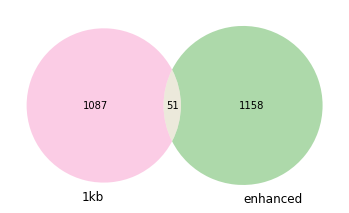

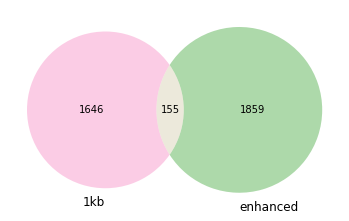

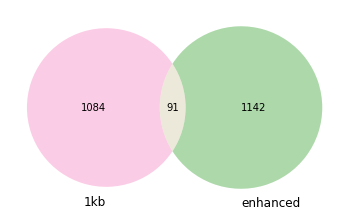

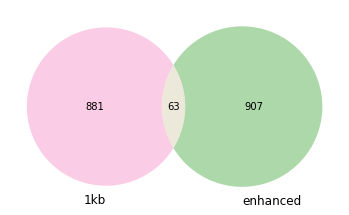

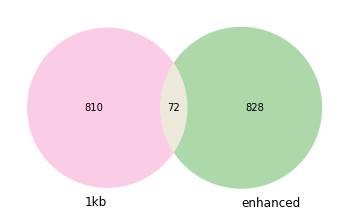

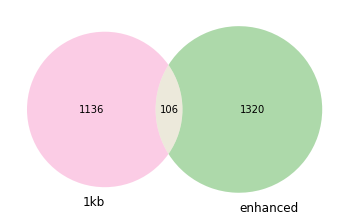

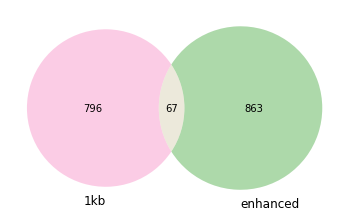

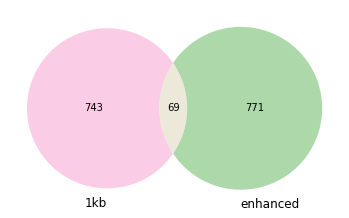

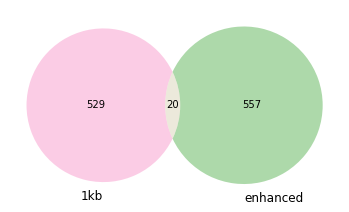

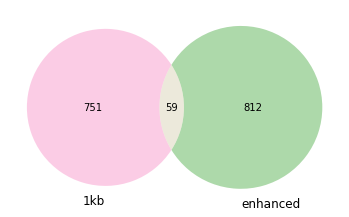

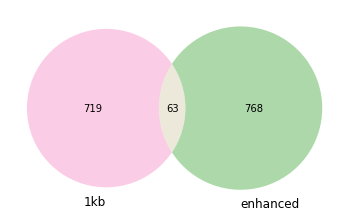

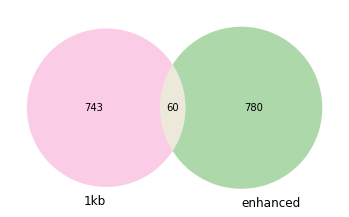

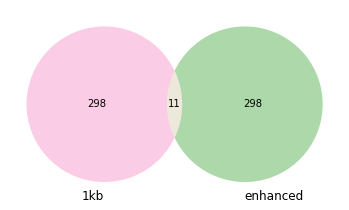

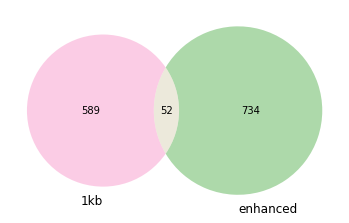

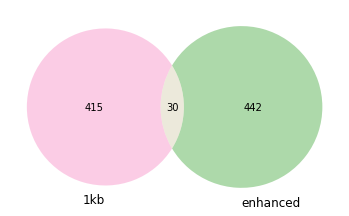

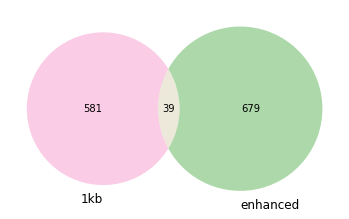

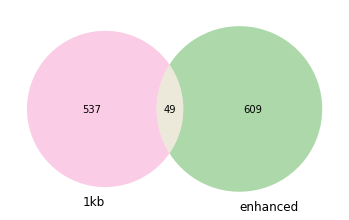

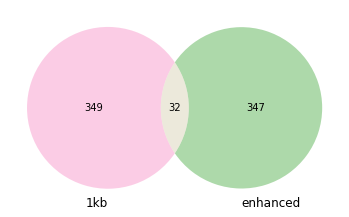

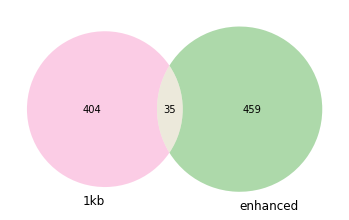

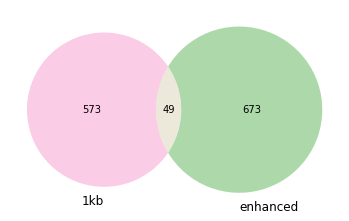

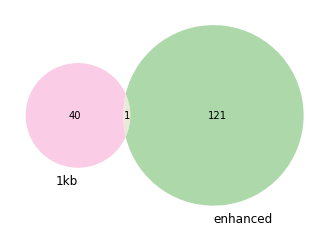

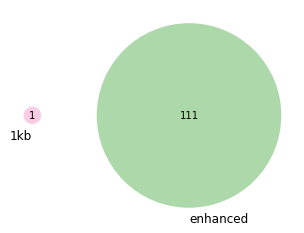

In [3]:
enhanced_path = os.path.join('/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac_H3K4me3_2_3/analyse/HepG2_ATAC_H3K27ac_H3K4me3_2_3', 'experiment', 'loop', 'enhanced')
hr_path = os.path.join('/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac_H3K4me3/analyse/HepG2_ATAC_H3K27ac_H3K4me3', 'experiment', 'loop', 'hr')
auxiliary_files_path = '/data1/lmh_data/MINE/source/GM12878'
proportion = 0.015

# 未去交集的全部sig
enhanced_sigs = set()
hr_sigs = set()
# 去交集的全部sig
all_enhanced_sig = dict()
all_hr_sig = dict()
for chr in range(1, 23):
    enhanced_file_path = os.path.join(enhanced_path, 'chr{}_1000b'.format(chr), 'outputs_2_100', 'FitHiC.spline_pass1.res1000.significances.txt')
    hr_file_path = os.path.join(hr_path, 'chr{}_1000b'.format(chr), 'outputs_2_100', 'FitHiC.spline_pass1.res1000.significances.txt')
    enhanced_sig = cal_significant_test(get_significant(enhanced_file_path), proportion)
    hr_sig = cal_significant(get_significant(hr_file_path), proportion)
    
    _enhanced_sig = set(list(map(tuple, np.array(enhanced_sig)[:, :2])))
    _hr_sig = set(list(map(tuple, np.array(hr_sig)[:, :2])))
    show_venn(_enhanced_sig, _hr_sig)
    # 去交集
    new_enhanced_sig = _enhanced_sig - _hr_sig
    new_hr_sig = _hr_sig - _enhanced_sig
    
    all_enhanced_sig[chr] = new_enhanced_sig
    all_hr_sig[chr] = new_hr_sig
    
    for sig in _enhanced_sig:
        _sig = list(sig)
        _sig.append('chr{}'.format(chr))
        enhanced_sigs.add(tuple(_sig))
    for sig in _hr_sig:
        _sig = list(sig)
        _sig.append('chr{}'.format(chr))
        hr_sigs.add(tuple(_sig))

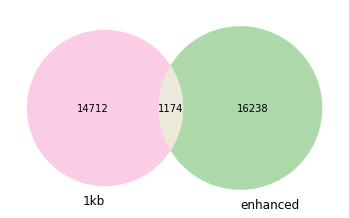

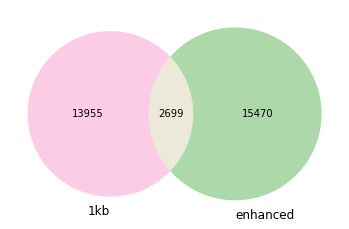

In [4]:
show_venn(enhanced_sigs, hr_sigs)
_enhanced_sigs = enhanced_sigs.copy()
_hr_sigs = set()
for _hr_sig in hr_sigs:
    flag = False
    for _enhanced_sig in _enhanced_sigs:
        if abs(_hr_sig[0]-_enhanced_sig[0])<3 and abs(_hr_sig[1]-_enhanced_sig[1])<3:
            _hr_sigs.add(_enhanced_sig)
            flag = True
    _hr_sigs.add(_hr_sig)
    if flag:
        _enhanced_sigs.add(_hr_sig)

show_venn(_enhanced_sigs, _hr_sigs)

In [5]:
attentions = 50
center = attentions - 1

def read_chiqseq_file(path):
    _peaks = dict()
    with open(path)as f:
        for line in f:
            datas = line.strip().split()
            left, right = int(int(datas[1])/1000), int(int(datas[2])/1000)
            peaks = list(range(left, right+1))
            if datas[0] not in _peaks.keys():
                _peaks[datas[0]] = set()
            for i in peaks:
                _peaks[datas[0]].add(i)
    return _peaks

def get_hit_indicators(significants, peaks):
    distance = np.zeros(attentions*2-1)
    
    for sig in significants:
        x, y = int(sig[0]), int(sig[1])
        for i in range(attentions):
            if (x+i) in peaks or (y+i) in peaks:
                distance[center-i] += 1
            if i != 0 and((x-i) in peaks or (y-i) in peaks):
                distance[center+i] += 1
            if (x+i) in peaks or (x-i) in peaks or (y+i) in peaks or (y-i) in peaks:
                break
    return distance

def show(x, mine_result, hr_result):
    sns.set_style("whitegrid") 
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
    axes.grid(False)
    axes.plot(x, mine_result, color=(51/255, 160/255, 44/255), label='mine')
    axes.plot(x, hr_result, color=(177/255, 89/255, 40/255), label='hr')

    plt.xlabel('distance')
    plt.ylabel('nums')
    plt.legend()
    plt.show()

def figure(chip_seq_path):
    all_enhanced_result = np.zeros(attentions*2-1)
    all_hr_result = np.zeros(attentions*2-1)

    for chr in range(1, 23):
        _peaks = read_chiqseq_file(chip_seq_path)
        enhanced_result = get_hit_indicators(all_enhanced_sig[chr], _peaks['chr{}'.format(chr)])
        hr_result = get_hit_indicators(all_hr_sig[chr], _peaks['chr{}'.format(chr)])

        all_enhanced_result += enhanced_result
        all_hr_result += hr_result

    show(list(range(-attentions+1, attentions)), all_enhanced_result, all_hr_result)

In [6]:
tss_file_path = os.path.join(auxiliary_files_path, 'Homo_sapiens.GRCh38.104.chr.gff3')

def get_tss_gene_info(gene_biotype='protein_coding'):
    gene_location = dict()
    gene_info = dict()
    with open(tss_file_path, "r") as f:
        datas = f.readlines()
        for data in datas[9:]:
            data = data.split('\t')
            if len(data) < 9:
                continue
            if data[2] != 'gene' or data[8].find(gene_biotype) == -1:
                continue
            if data[6] == '+':
                _location = data[3]
            elif data[6] == '-':
                _location = data[4]
            else:
                print('error')
            if not data[0].isdigit():
                continue
            chromosome = int(data[0])
            if chromosome not in gene_location:
                gene_location[chromosome] = set()
            gene_location[chromosome].add(int(int(_location)/1000))
            
            _tmp = data[-1].split('Name=')
            if len(_tmp) < 2:
                continue
            gene_names = _tmp[1].split(';')[0]
            gene_ids = data[-1].split('ID=')[1].split(',')[0].split(';')[0]
            
            if chromosome not in gene_info:
                gene_info[chromosome] = set()
            gene_info[chromosome].add((int(int(_location)/1000), gene_names, gene_ids, data[-1].replace('\n', '')))
    return gene_location, gene_info

def figure_tss(locations):
    all_enhanced_result = np.zeros(attentions*2-1)
    all_hr_result = np.zeros(attentions*2-1)

    for chr in range(1, 23):
        if chr not in locations:
            continue
        enhanced_result = get_hit_indicators(all_enhanced_sig[chr], locations[chr])
        hr_result = get_hit_indicators(all_hr_sig[chr], locations[chr])

        all_enhanced_result += enhanced_result
        all_hr_result += hr_result

    show(list(range(-attentions+1, attentions)), all_enhanced_result, all_hr_result)

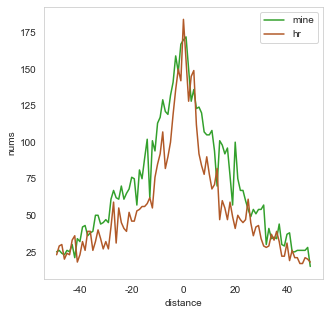

In [7]:
figure_tss(get_tss_gene_info('protein_coding')[0])

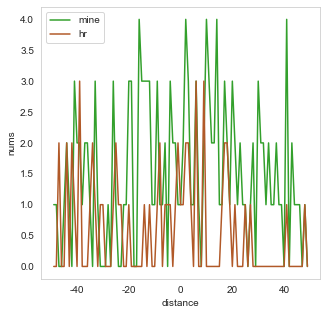

In [8]:
figure_tss(get_tss_gene_info('pseudogene')[0])

In [9]:
def get_hit_genes(significants, gene_info, genes_loop_nums):
    genes = set()
    for sig in significants:
        x, y = int(sig[0]), int(sig[1])
        for _info in gene_info:
            if abs(x-_info[0])<3 or abs(y-_info[0])<3:
                if _info[1] not in genes_loop_nums:
                    genes_loop_nums[_info[1]] = 1
                else:
                    genes_loop_nums[_info[1]] += 1
                genes.add((_info[1], _info[2], _info[3]))
    return genes, genes_loop_nums

def get_hit_gene_names(significants, gene_biotype='protein_coding'):
    gene_info = get_tss_gene_info(gene_biotype)[1]
    all_genes = set()
    genes_loop_nums = dict()
    for chr in range(1, 23):
        genes, genes_loop_nums = get_hit_genes(significants[chr], gene_info[chr], genes_loop_nums)
        all_genes = all_genes | genes
    return all_genes, genes_loop_nums

In [10]:
mine_hit_genes, mine_genes_loop_nums = get_hit_gene_names(all_enhanced_sig, gene_biotype='protein_coding')
mine_hit_genes = list(mine_hit_genes)
mine_hit_genes = np.array(mine_hit_genes)
print(len(mine_hit_genes))
print(mine_genes_loop_nums.keys())

782
dict_keys(['PYHIN1', 'MNDA', 'CDK11B', 'CDK11A', 'LCE4A', 'FCGR2B', 'FCRLB', 'UBE2J2', 'USH2A', 'CD34', 'PRAMEF9', 'MACO1', 'RHCE', 'H2BC21', 'H2AC20', 'BEST4', 'KDM1A', 'CCDC190', 'TNFRSF14', 'TARS2', 'MCL1', 'PHLDA3', 'S100A7A', 'GPR89B', 'RCC2', 'FCGR3B', 'FAM102B', 'PRAMEF11', 'CD2', 'H2BU1', 'H2AW', 'FCGR1B', 'A3GALT2', 'FDPS', 'IVL', 'C1orf159', 'NBPF4', 'FAM229A', 'DVL1', 'MAP3K21', 'NBPF12', 'NBPF9', 'LAMB3', 'PADI3', 'SMIM42', 'OR6Y1', 'LDLRAD1', 'PRAMEF4', 'OR2T4', 'RUNX3', 'PLEKHN1', 'IFI44', 'TNNI1', 'PAPPA2', 'NBPF20', 'ZNF669', 'GCLM', 'TMEM52', 'PANK4', 'MIA3', 'DYNLT5', 'CHI3L1', 'OR6N2', 'ERI3', 'SLC16A4', 'OR2T8', 'ITGA10', 'CSDE1', 'HJV', 'NBPF11', 'DENND1B', 'MTRNR2L11', 'PKN2', 'DNM3', 'B4GALT3', 'CFHR5', 'ANGEL2', 'PTCH2', 'OR6P1', 'TNFRSF4', 'QSOX1', 'CHD5', 'PTBP2', 'PRAMEF20', 'DIRAS3', 'FAM20B', 'AMY2B', 'RPE65', 'SYDE2', 'POGK', 'IRF6', 'FOXJ3', 'TTC30A', 'PUM2', 'SP140L', 'SP100', 'LRP2', 'HDLBP', 'SEPTIN2', 'TUBA4B', 'ABCB6', 'REG1A', 'CAPN10', 'COX5B',

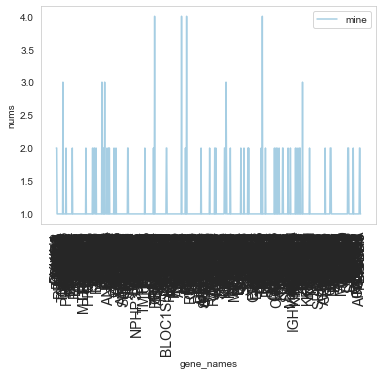

In [11]:
x = list(mine_genes_loop_nums.keys())
y = list(mine_genes_loop_nums.values())

sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
axes.grid(False)
axes.plot(x, y, color=(166/255, 206/255, 227/255), label='mine')

plt.xticks(rotation=90, fontsize=14)

# plt.ylim(0, 1)
plt.xlabel('gene_names')
plt.ylabel('nums')
# plt.xlim(0, len(significants))
plt.legend()
plt.show()

In [12]:
hr_hit_genes, hr_genes_loop_nums = get_hit_gene_names(all_hr_sig, gene_biotype='protein_coding')
hr_hit_genes = list(hr_hit_genes)
hr_hit_genes = np.array(hr_hit_genes)
print(len(hr_hit_genes))
print(hr_genes_loop_nums.keys())

670
dict_keys(['KIF17', 'PRAMEF10', 'PRAMEF25', 'PRAMEF33', 'OR2T3', 'EPS15', 'TNFRSF14', 'RWDD3', 'ODF2L', 'NGF', 'LRRC8B', 'CDK11B', 'CCDC18', 'TMED5', 'BCL2L15', 'CHD5', 'PRAMEF5', 'GPSM2', 'OR2T5', 'AJAP1', 'STRIP1', 'SH3GLB1', 'PGBD2', 'COX20', 'SLC35E2B', 'TMEM52', 'PRAMEF9', 'PRAMEF18', 'ATAD3B', 'SKI', 'FAM131C', 'CTNNBIP1', 'SLC25A24', 'WARS2', 'NBPF9', 'PADI2', 'PRAMEF15', 'AK5', 'BCAR3', 'LRIF1', 'TRIM62', 'MMP23B', 'PANK4', 'OR2W3', 'TRAPPC3', 'MAP7D1', 'VWA1', 'TMEM88B', 'HSPG2', 'OR2C3', 'OR2L5', 'NBPF6', 'FAAP20', 'TRIM45', 'PRAMEF14', 'PRAMEF6', 'SLC16A4', 'GNG12', 'NBPF4', 'ZNF362', 'WNT2B', 'ID3', 'CCN1', 'OLFM3', 'HNRNPCL2', 'NBPF1', 'FOXD3', 'MAP2', 'ATP6V1B1', 'CFC1', 'KLHL30', 'ASB1', 'ANKRD36B', 'RIF1', 'STON1-GTF2A1L', 'STON1', 'ALK', 'AMER3', 'MOGAT1', 'FIGLA', 'MAP3K2', 'STEAP3', 'SPEG', 'GPR17', 'HOXD8', 'HOXD4', 'MZT2B', 'FAM178B', 'PDCD1', 'ZAP70', 'AQP12A', 'AQP12B', 'POTEI', 'XDH', 'PCBP1', 'TWIST2', 'UGT1A8', 'ATL2', 'ILKAP', 'TMEFF2', 'STAT4', 'FAM161A'

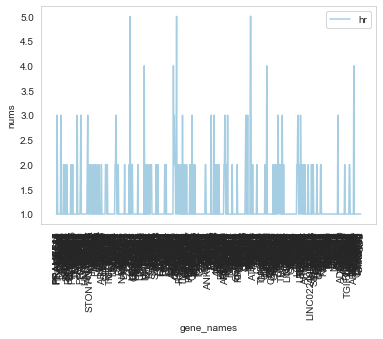

In [13]:
from matplotlib import ticker
x = list(hr_genes_loop_nums.keys())
y = list(hr_genes_loop_nums.values())

sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
axes.grid(False)
axes.plot(x, y, color=(166/255, 206/255, 227/255), label='hr')

# axes.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.xticks(rotation=90, fontsize=10)

# plt.ylim(0, 1)
plt.xlabel('gene_names', fontsize=10)
plt.ylabel('nums')
# plt.xlim(0, len(significants))
plt.legend()
plt.show()

In [14]:
np.save('temp/HepG2_ATAC_H3K27ac_H3K4me3_2_100_all_enhanced_sig.npy', all_enhanced_sig)
np.save('temp/HepG2_ATAC_H3K27ac_H3K4me3_2_100_all_hr_sig.npy', all_hr_sig)

np.save('temp/HepG2_ATAC_H3K27ac_H3K4me3_2_100_enhanced_sigs.npy', enhanced_sigs)
np.save('temp/HepG2_ATAC_H3K27ac_H3K4me3_2_100_hr_sigs.npy', hr_sigs)

np.save('temp/HepG2_ATAC_H3K27ac_H3K4me3_2_100__enhanced_sigs.npy', _enhanced_sigs)
np.save('temp/HepG2_ATAC_H3K27ac_H3K4me3_2_100__hr_sigs.npy', _hr_sigs)